In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.feature_detection.class_frame_pair import FramePair



Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
fname = "/home/charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

Output files: /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/global2tracklet_manual.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/manually_split_tracklets.h5, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_names.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [10]:
# Centerline only for this dataset
fname = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_X_coords.csv"
centerlineX = pd.read_csv(fname, header=None)
fname = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_Y_coords.csv"
centerlineY = pd.read_csv(fname, header=None)
fname = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_K.csv"
centerlineK = pd.read_csv(fname, header=None)

In [295]:
# #load the two images into numpy arrays
# folder = "/home/charles/dlc_stacks/wbfm_ulises_centerline_for_charlie/test_images"
# import tifffile as tiff

# path_img1=f'{folder}/Result of 2021-03-04_16-17-30_worm3_ZIM2051-channel-0-bigtiff_volume_537.tif'
# img1=tiff.imread(path_img1)
# path_img2=f'{folder}/MAX_2021-03-04_16-07-57_worm3_ZIM2051-channel-0-pco_camera1bigtiff-1.tif'
# img2=tiff.imread(path_img2)

# Look at the point clouds raw, and then try to align them

In [180]:
from DLC_for_WBFM.utils.external.centerline_utils import get_full_transformation_fluo_to_behavior, get_full_transformation_behavior_to_fluo
from skimage import transform
from DLC_for_WBFM.utils.nn_utils.data_formatting import zimmer2physical_behavior, zimmer2physical_fluorescence

In [294]:
centerlineX.shape

(67996, 100)

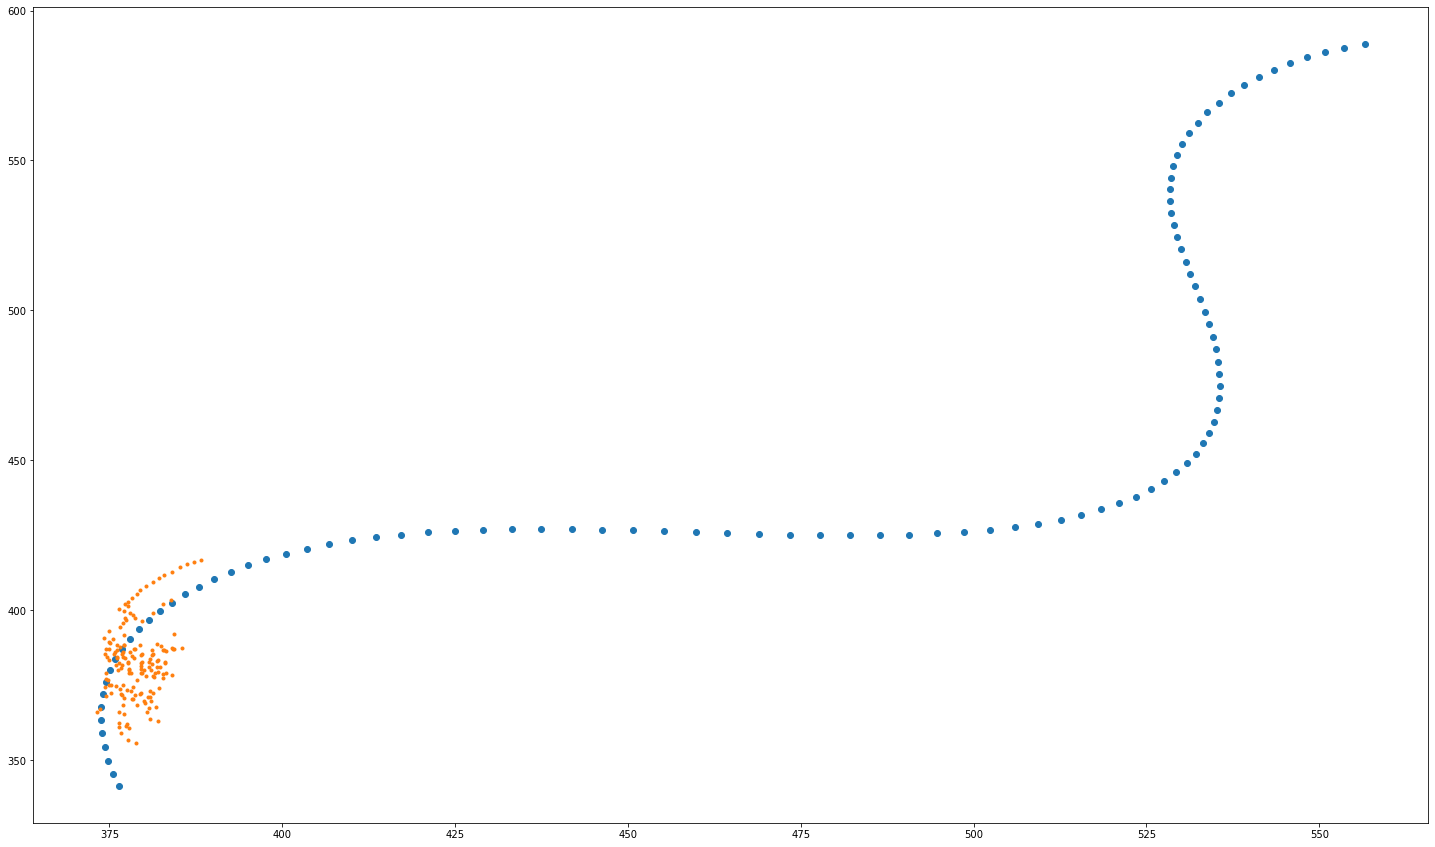

In [293]:
t = 10
fps = 32
tform2 = get_full_transformation_fluo_to_behavior()


pts0 = project_data.get_centroids_as_numpy(t)
# pts0_um = zimmer2physical_fluorescence(pts0)

c_x = centerlineX.iloc[t*fps]
c_y = centerlineY.iloc[t*fps]
centerline0 = np.vstack([c_x, c_y]).T
# centerline0_um = zimmer2physical_behavior(centerline0)

pts0_transformed = transform.matrix_transform(pts0[:, [2, 1]], tform2.params)
# pts0_transformed = tform2.params[:-1, :-1] @ (pts0[:, [2, 1]] - tform2.translation[[1,0]]).T

plt.figure(figsize=(25,15))
plt.plot(centerline0[:, 0], centerline0[:, 1], 'o')
plt.plot(pts0_transformed[:, 1], pts0_transformed[:, 0], '.')

# Do the above with classes

In [298]:
from dataclasses import dataclass
from backports.cached_property import cached_property


@dataclass
class WormFullVideoPosture:

    filename_curvature: str
    filename_x: str
    filename_y: str

    curvature: pd.DataFrame = None
    centerlineX: pd.DataFrame = None
    centerlineY: pd.DataFrame = None
    pca_i_start: int = 10
    pca_i_end: int = -10
    
    fps: int = 32

    @cached_property
    def pca_projections(self):
        pca = PCA(n_components=3, whiten=True)
        curvature_nonan = self.curvature.replace(np.nan, 0.0)
        pca_proj = pca.fit_transform(curvature_nonan.iloc[:, self.pca_i_start:self.pca_i_end])

        return pca_proj

    def __post_init__(self):
        self.centerlineX = pd.read_csv(self.filename_x, header=None)
        self.centerlineY = pd.read_csv(self.filename_y, header=None)
        self.curvature  = pd.read_csv(self.filename_curvature, header=None)

    def plot_pca(self):
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')
        c = np.arange(self.curvature.shape[0]) / 1e6
        plt.scatter(self.pca_projections[:, 0], self.pca_projections[:, 1], self.pca_projections[:, 2], c=c)
        plt.colorbar()
        
    def get_centerline_for_time(self, t):
        c_x = centerlineX.iloc[t*self.fps]
        c_y = centerlineY.iloc[t*self.fps]
        return np.vstack([c_x, c_y]).T

In [726]:
def transform_neuron_point_cloud(pts):
    tform2 = get_full_transformation_fluo_to_behavior()
    pts_transformed = transform.matrix_transform(pts[:, [2, 1]], tform2.params)
    
    new_pts = np.zeros_like(pts)
    new_pts[:, 0] = pts[:, 0]
    new_pts[:, 1] = pts_transformed[:, 1]
    new_pts[:, 2] = pts_transformed[:, 0]
    
    return new_pts

In [299]:

fname1 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_X_coords.csv"
fname2 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_Y_coords.csv"
fname3 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_K.csv"

worm_posture = WormFullVideoPosture(fname1, fname2, fname3)

In [303]:
pts = project_data.get_centroids_as_numpy(0)
centerline0 = worm_posture.get_centerline_for_time(0)
pts0_transformed = transform_neuron_point_cloud(pts)

In [306]:

# plt.figure(figsize=(25,15))
# plt.plot(centerline0[:, 0], centerline0[:, 1], 'o')
# plt.plot(pts0_transformed[:, 1], pts0_transformed[:, 2], '.')

# Given an anchor point, get the closest centerline point and transform using diff vector

In [308]:
worm_posture
project_data

Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True

In [484]:
from sklearn.neighbors import NearestNeighbors

t = 0
i_anchor = 17

pts = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
anchor_pt = pts[i_anchor]

centerline = worm_posture.get_centerline_for_time(t)

In [485]:
centerline_neighbors = NearestNeighbors(n_neighbors=3).fit(centerline)

n_neighbors = 1
closest_centerline_dist, closest_centerline_ind = centerline_neighbors.kneighbors(anchor_pt[1:].reshape(1, -1), n_neighbors)
closest_centerline_pt = centerline[closest_centerline_ind[0][0], :]

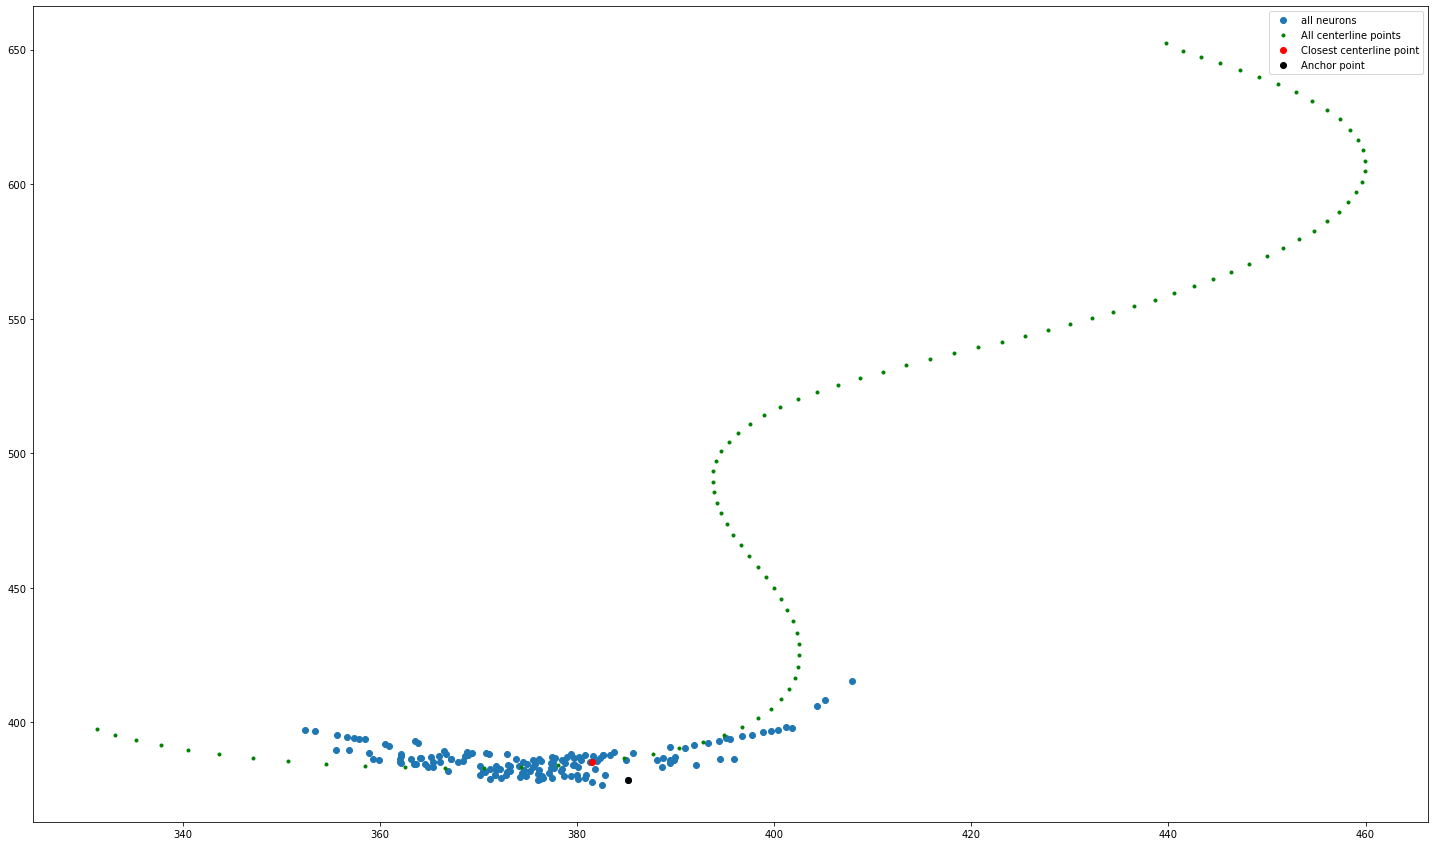

In [486]:
plt.figure(figsize=(25,15))
plt.plot(pts[:, 1], pts[:, 2], 'o', label="all neurons")
plt.plot(centerline[:, 0], centerline[:, 1], 'g.', label="All centerline points")
plt.plot(closest_centerline_pt[0], closest_centerline_pt[1], 'ro', label="Closest centerline point")
plt.plot(anchor_pt[1], anchor_pt[2], 'ko', label="Anchor point")
plt.legend()

In [491]:
centerline_tangent = centerline[closest_centerline_ind[0][0] + 1, :] - closest_centerline_pt
angle = np.arctan2(centerline_tangent[0], centerline_tangent[1])
matrix = transform.EuclideanTransform(rotation=angle)
print(angle, closest_centerline_ind, centerline_tangent, closest_centerline_pt)

1.1686573607806812 [[15]] [3.22781207 1.37284277] [381.48083064 385.25480891]


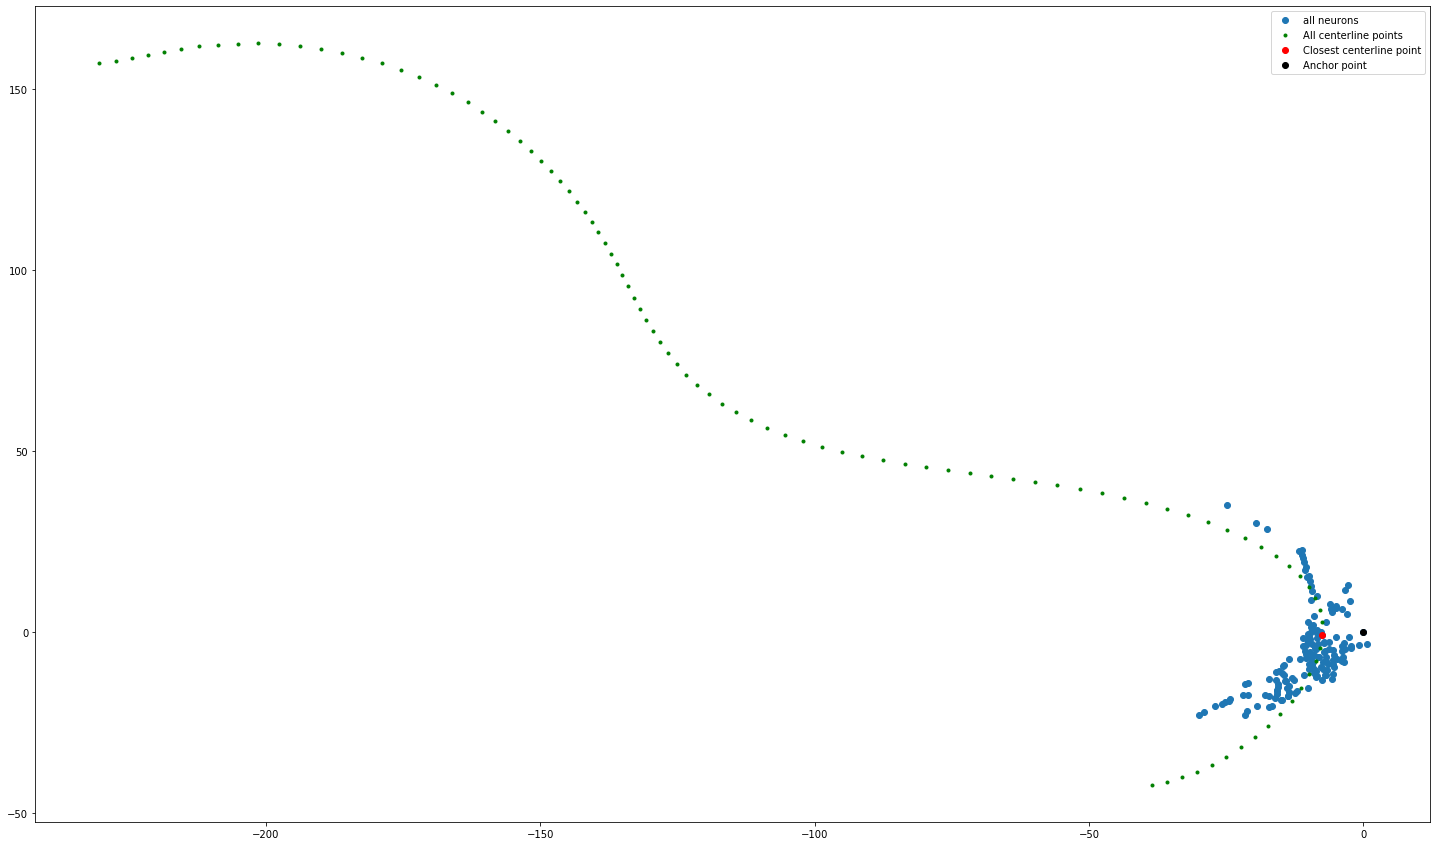

In [488]:
plt.figure(figsize=(25,15))

pts2 = transform.matrix_transform(pts[:, 1:] - anchor_pt[1:], matrix.params)
centerline2 = transform.matrix_transform(centerline - anchor_pt[1:], matrix.params)
closest_centerline_pt2 = transform.matrix_transform(closest_centerline_pt - anchor_pt[1:], matrix.params)[0]
anchor2 = transform.matrix_transform(anchor_pt[1:] - anchor_pt[1:], matrix.params)[0]

plt.plot(pts2[:, 0], pts2[:, 1], 'o', label="all neurons")
plt.plot(centerline2[:, 0], centerline2[:, 1], 'g.', label="All centerline points")
plt.plot(closest_centerline_pt2[0], closest_centerline_pt2[1], 'ro', label="Closest centerline point")
plt.plot(anchor2[0], anchor2[1], 'ko', label="Anchor point")
plt.legend()

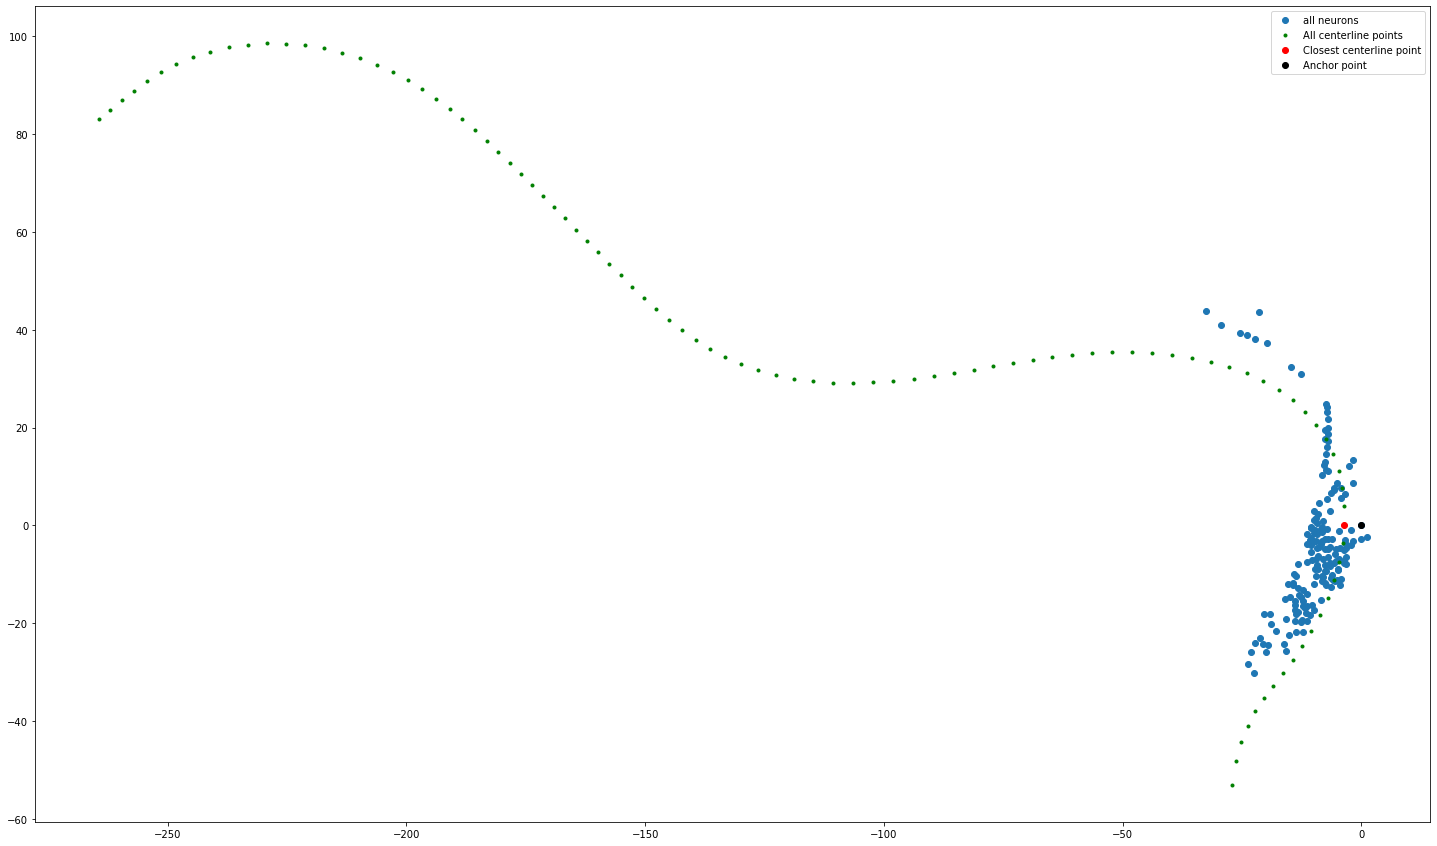

In [468]:
plt.figure(figsize=(25,15))

pts2 = transform.matrix_transform(pts[:, 1:] - anchor_pt[1:], matrix.params)
centerline2 = transform.matrix_transform(centerline - anchor_pt[1:], matrix.params)
closest_centerline_pt2 = transform.matrix_transform(closest_centerline_pt - anchor_pt[1:], matrix.params)[0]
anchor2 = transform.matrix_transform(anchor_pt[1:] - anchor_pt[1:], matrix.params)[0]

plt.plot(pts2[:, 0], pts2[:, 1], 'o', label="all neurons")
plt.plot(centerline2[:, 0], centerline2[:, 1], 'g.', label="All centerline points")
plt.plot(closest_centerline_pt2[0], closest_centerline_pt2[1], 'ro', label="Closest centerline point")
plt.plot(anchor2[0], anchor2[1], 'ko', label="Anchor point")
plt.legend()

# Classes for above, and do ICP to get a pairwise distance

In [367]:
worm_posture
project_data

Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True

In [638]:
from dataclasses import dataclass
from backports.cached_property import cached_property


@dataclass
class WormSinglePosture:
    
    neuron_zxy: np.ndarray
    centerline: np.ndarray
    
    centerline_neighbors: NearestNeighbors = None
    neuron_neighbors: NearestNeighbors = None

    def __post_init__(self):
        self.centerline_neighbors = NearestNeighbors(n_neighbors=2).fit(self.centerline)
        self.neuron_neighbors = NearestNeighbors(n_neighbors=5).fit(self.neuron_zxy)

    def get_closest_centerline_point(self, anchor_pt):
        n_neighbors = 1
        closest_centerline_dist, closest_centerline_ind = self.centerline_neighbors.kneighbors(anchor_pt[1:].reshape(1, -1), n_neighbors)
        closest_centerline_pt = self.centerline[closest_centerline_ind[0][0], :]
        
        return closest_centerline_pt, closest_centerline_ind
    
    def get_transformation_using_centerline_tangent(self, anchor_pt):
        closest_centerline_pt, closest_centerline_ind = self.get_closest_centerline_point(anchor_pt)
        
        centerline_tangent = self.centerline[closest_centerline_ind[0][0] + 1, :] - closest_centerline_pt
        angle = np.arctan2(centerline_tangent[0], centerline_tangent[1])
        # angle = np.angle(centerline_tangent[0] + 1j * centerline_tangent[1])
        # print(f"Rotation angle of {angle} with centerline index {closest_centerline_ind} and tangent {centerline_tangent} (pt={closest_centerline_pt})")
        matrix = transform.EuclideanTransform(rotation=angle)
        
        return matrix
    
    def get_neighbors(self, anchor_pt, n_neighbors):
        
        neighbor_dist, neighbor_ind = self.neuron_neighbors.kneighbors(anchor_pt.reshape(1, -1), n_neighbors + 1)
        # Closest neighbor is itself
        neighbor_dist = neighbor_dist[0][1:]
        neighbor_ind = neighbor_ind[0][1:]
        neighbors_zxy = self.neuron_zxy[neighbor_ind, :]
        
        return neighbors_zxy, neighbor_ind

    def get_neighbors_in_local_coordinate_system(self, i_anchor, n_neighbors=10):
        
        anchor_pt = self.neuron_zxy[i_anchor]        
        neighbors_zxy, neighbor_ind = self.get_neighbors(anchor_pt, n_neighbors)
        
        matrix = self.get_transformation_using_centerline_tangent(anchor_pt)
        new_pts = transform.matrix_transform(neighbors_zxy[:, 1:] - anchor_pt[1:], matrix.params)
        
        new_pts_zxy = np.zeros_like(neighbors_zxy)
        new_pts_zxy[:, 0] = neighbors_zxy[:, 0]
        new_pts_zxy[:, 1] = new_pts[:, 0]
        new_pts_zxy[:, 2] = new_pts[:, 1]
        # TODO: add z back in
        return new_pts_zxy
    
    
    def get_all_neurons_in_local_coordinate_system(self, i_anchor, n_neighbors=10):
        
        anchor_pt = self.neuron_zxy[i_anchor]        
        
        matrix = self.get_transformation_using_centerline_tangent(anchor_pt)
        new_pts = transform.matrix_transform(self.neuron_zxy[:, 1:] - anchor_pt[1:], matrix.params)
        
        # TODO: add z back in
        return new_pts

In [727]:
t = 0
pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
centerline0 = worm_posture.get_centerline_for_time(t)
worm0 = WormSinglePosture(pts0, centerline0)

t = 1
pts1 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
centerline1 = worm_posture.get_centerline_for_time(t)
worm1 = WormSinglePosture(pts1, centerline1)


In [729]:
n_neighbors = 20

n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=50, n_neighbors=n_neighbors)
n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=51, n_neighbors=n_neighbors)

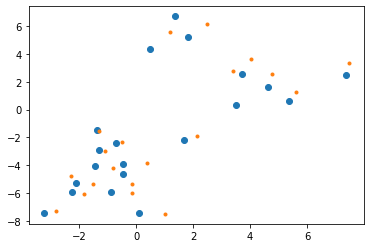

In [730]:
plt.plot(n0[:, 1], n0[:, 2], 'o')
plt.plot(n1[:, 1], n1[:, 2], '.')

In [731]:
# from DLC_for_WBFM.utils.external.icp import icp

In [732]:
reg = pc_distance_using_icp(n0, n1)
reg.inlier_rmse

0.4982792014953672

In [733]:
import open3d as o3d

def pc_distance_using_icp(n0, n1):

    pc0 = o3d.geometry.PointCloud()
    pc0.points = o3d.utility.Vector3dVector(n0)
    pc1 = o3d.geometry.PointCloud()
    pc1.points = o3d.utility.Vector3dVector(n1)

    options = {'max_correspondence_distance': 1.0, 'criteria': o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=20)}
    reg = o3d.pipelines.registration.registration_icp(pc0, pc1, **options)
    
    return reg

In [734]:
n_neighbors = 100
from tqdm.auto import tqdm
num0 = len(worm0.neuron_zxy)
num1 = len(worm1.neuron_zxy)
all_dist = np.zeros((num0, num1))
all_fitness = np.zeros((num0, num1))

for i in tqdm(range(num0)):
    n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i, n_neighbors=n_neighbors)
    for j in range(num1):
        n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=j, n_neighbors=n_neighbors)
        
        reg = pc_distance_using_icp(n0, n1)
        all_dist[i, j] = reg.inlier_rmse
        all_fitness[i, j] = reg.fitness
        

  0%|          | 0/155 [00:00<?, ?it/s]

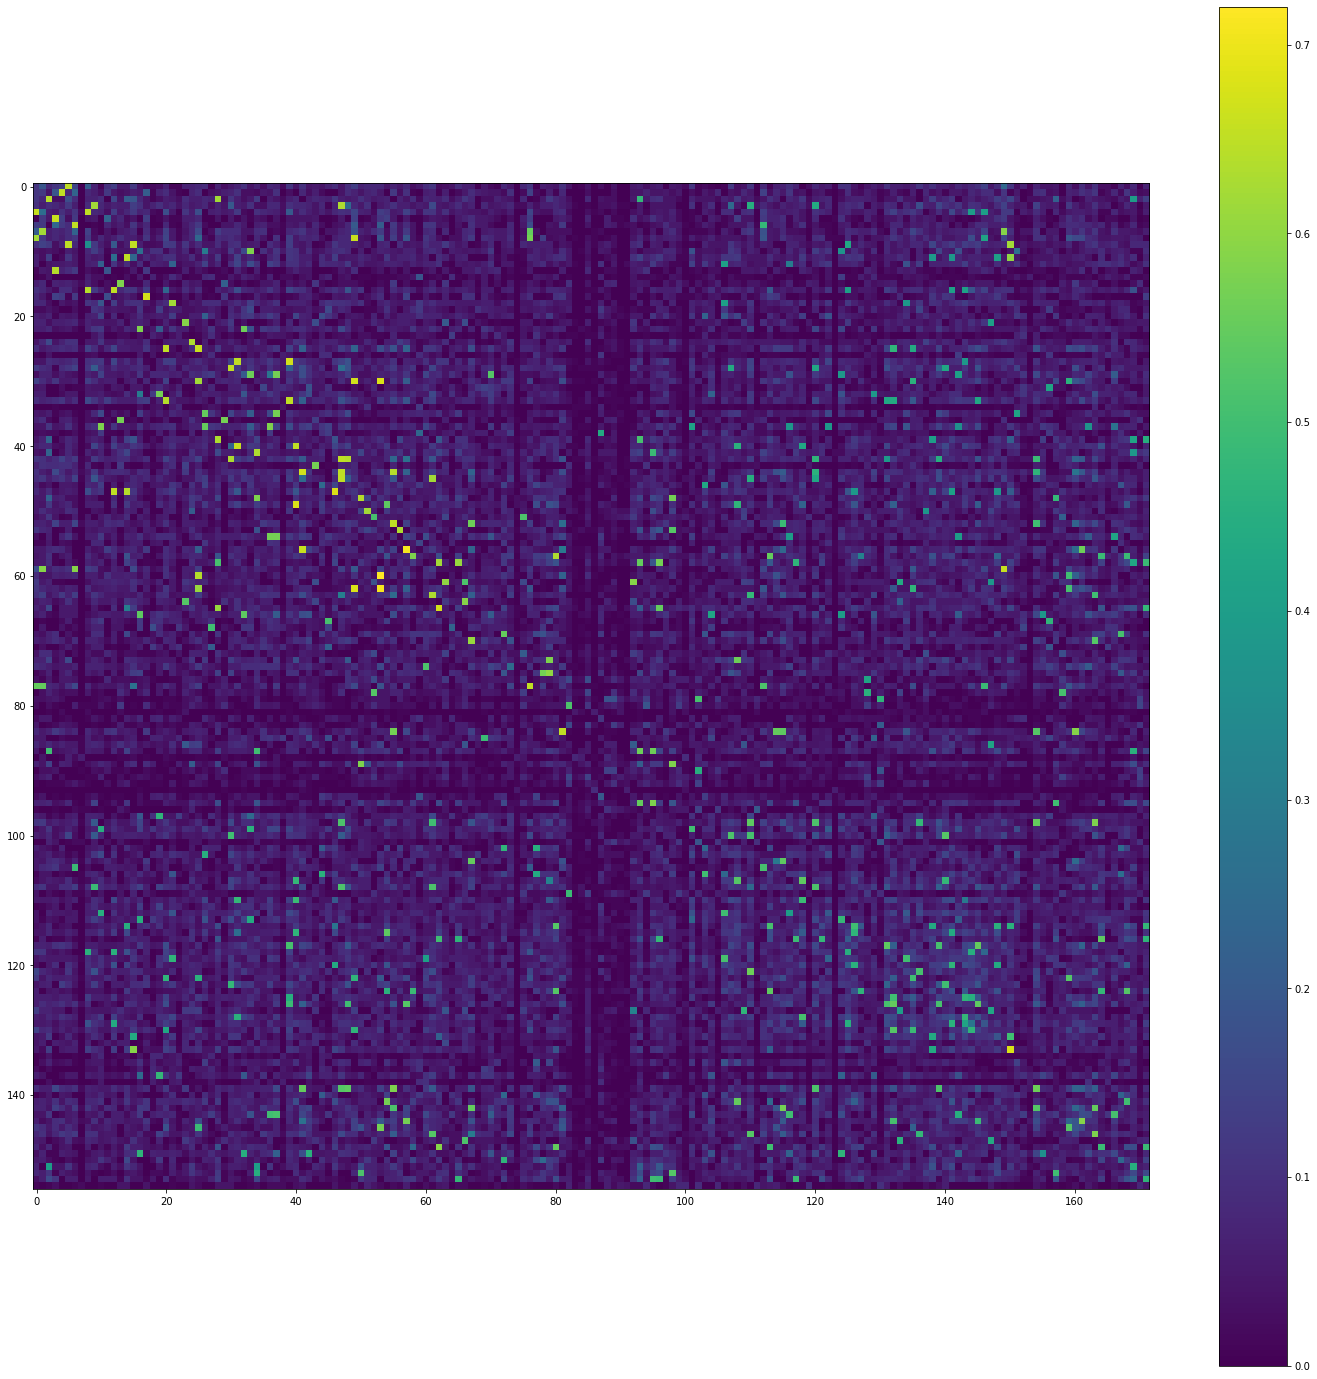

In [750]:
plt.figure(figsize=(25,25))
plt.imshow(all_fitness)
plt.colorbar()

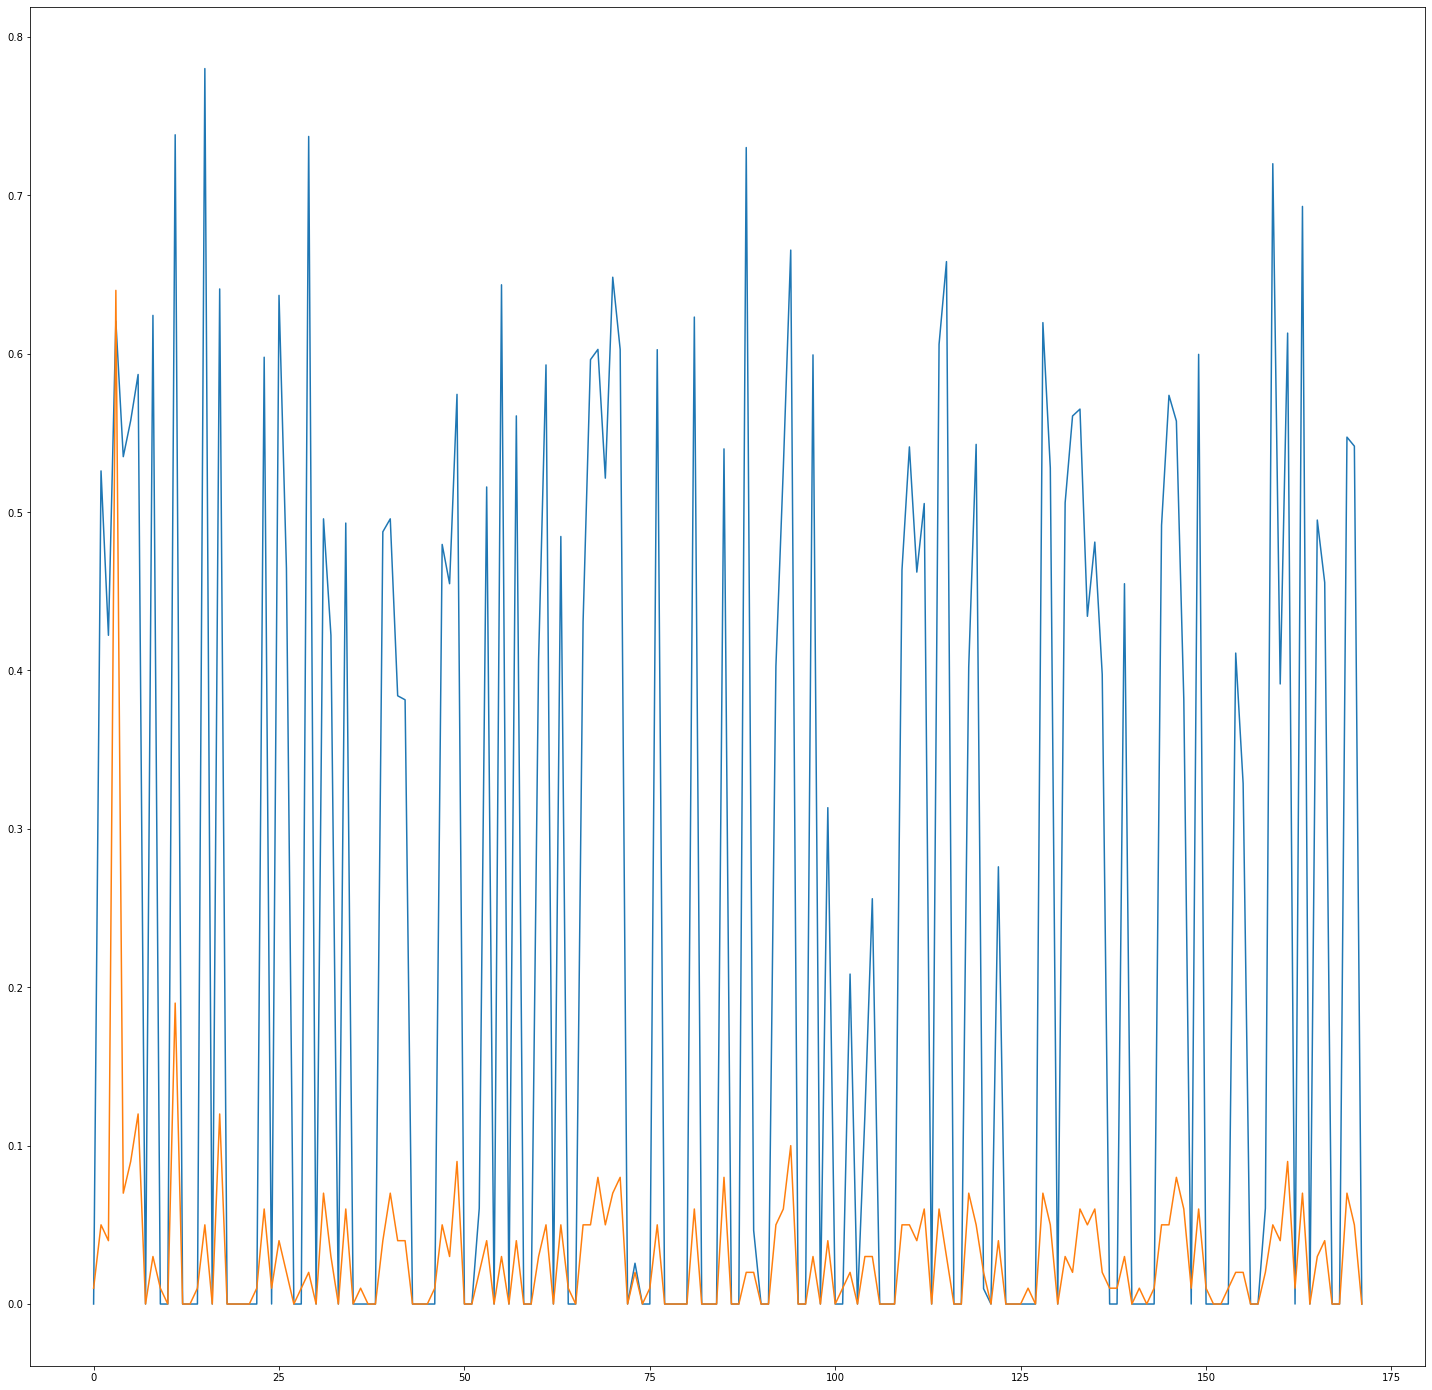

In [749]:
plt.figure(figsize=(25,25))
i = 13
plt.plot(all_dist[i, :])
plt.plot(all_fitness[i, :])
# plt.xlim(130, 140)

In [739]:
worm1.neuron_zxy[137]

array([ 25.01039604, 386.45166612, 388.07846549])

In [689]:
all_dist.shape

(155, 172)

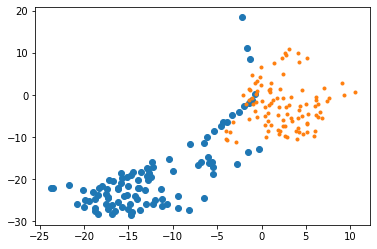

In [675]:
plt.plot(n0[:, 1], n0[:, 2], 'o')
plt.plot(n1[:, 1], n1[:, 2], '.')

In [536]:
# residual, pose = icp_obj.registerModelToScene(n0, n1)

In [538]:
import pcl
cloud_in = pcl.PointCloud()
cloud_out = pcl.PointCloud()

cloud_in.from_array(n0)
cloud_out.from_array(n1)

icp = cloud_in.make_IterativeClosestPoint()
converged, transf, estimate, fitness = icp.icp(cloud_in, cloud_out)

ImportError: libpcl_keypoints.so.1.7: cannot open shared object file: No such file or directory

In [740]:
project_data.napari_of_single_match((0,1))

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(15.5, 349.5, 449.5), zoom=1.8524320457796852, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=4, ndisplay=3, last_used=3, range=((0.0, 1.0, 1.0), (0.0, 31.0, 1.0), (0.0, 699.0, 1.0), (0.0, 899.0, 1.0)), current_step=(0, 0, 0, 0), order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'raw_red_data' at 0x7fc7ecd441d0>, <Points layer 'n0_zxy_raw' at 0x7fc7e5656410>, <Points layer 'n1_zxy_raw' at 0x7fc805fe1310>, <Tracks layer 'final_matches' at 0x7fc7d42ce350>, <Points layer 'Raw IDs' at 0x7fc7cddc70d0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(vi

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/asyncio/base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/asyncio/base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/pyth

In [365]:
import cv2

In [366]:
cv2.ppf_match_3d_ICP()

Init signature: cv2.ppf_match_3d_ICP(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           ~/anaconda3/envs/torch/lib/python3.7/site-packages/cv2.cpython-37m-x86_64-linux-gnu.so
Type:           type
Subclasses:     


In [364]:
closest_centerline_pt2

array([-5.80520083, -0.1134225 ])

In [345]:
closest_centerline_pt

array([362.51384276, 383.22937994])

# Scratch

In [194]:
# Just plot the centroid of the point cloud

In [199]:
from ipywidgets import interact

def f(t):
    pts0 = project_data.get_centroids_as_numpy(t)
    centroid = np.median(pts0, axis=0)
    
    plt.plot(pts0[:, 1], pts0[:, 2], '.')
    plt.plot(centroid[1], centroid[2], 'ro')
    
    plt.show()

In [200]:
interact(f, t=(1,1000))

interactive(children=(IntSlider(value=500, description='t', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.f(t)>

# Do the inverse transformation

In [182]:
t = 0
fps = 32
tform1 = get_full_transformation_behavior_to_fluo()


In [ ]:
pts0 = project_data.get_centroids_as_numpy(t)
# pts0_um = zimmer2physical_fluorescence(pts0)

c_x = centerlineX.iloc[t*fps]
c_y = centerlineY.iloc[t*fps]
centerline0 = np.vstack([c_x, c_y]).T
# centerline0_um = zimmer2physical_behavior(centerline0)

In [193]:
# centerline0_transformed = transform.matrix_transform(centerline0[:, [1,0]], tform1.params)
# centerline0_transformed = centerline0[:, [1,0]] @ tform1.params[:-1, :-1] + tform1.translation

# plt.figure(figsize=(25,15))
# plt.plot(centerline0_transformed[:, 0], centerline0_transformed[:, 1], 'o')
# plt.plot(pts0[:, 1], pts0[:, 2], '.')

In [179]:
# centerline0_transformed = transform.matrix_transform(centerline0, tform2.params)

# plt.figure(figsize=(25,15))
# plt.plot(centerline0_transformed[:, 0], centerline0_transformed[:, 1], 'o')
# plt.plot(pts0[:, 1], pts0[:, 2], '.')

In [115]:
# plt.hist(pts0)

In [116]:
# plt.hist(centerline0.T);

In [117]:
# plt.hist(centerline0_transformed)

In [118]:
# plt.hist(pts0_transformed)

In [128]:
dat = pts0[:, 1:]
out = tform2.params[:-1, :-1] @ dat.T + np.expand_dims(tform2.translation, axis=-1)

In [135]:
# out.T

In [110]:
# out = transform.warp(pts0[:, 1:], tform2)

In [112]:
# plt.hist(out)

In [100]:
# out = tform2.params @ pts0.T
out = centerline0.T @ tform2.params[:-1,:]

In [136]:
# plt.hist(out[:, :-1])

In [137]:
# plt.plot(out[:, 0], out[:, 1])

In [138]:
# out

# Plot over the images

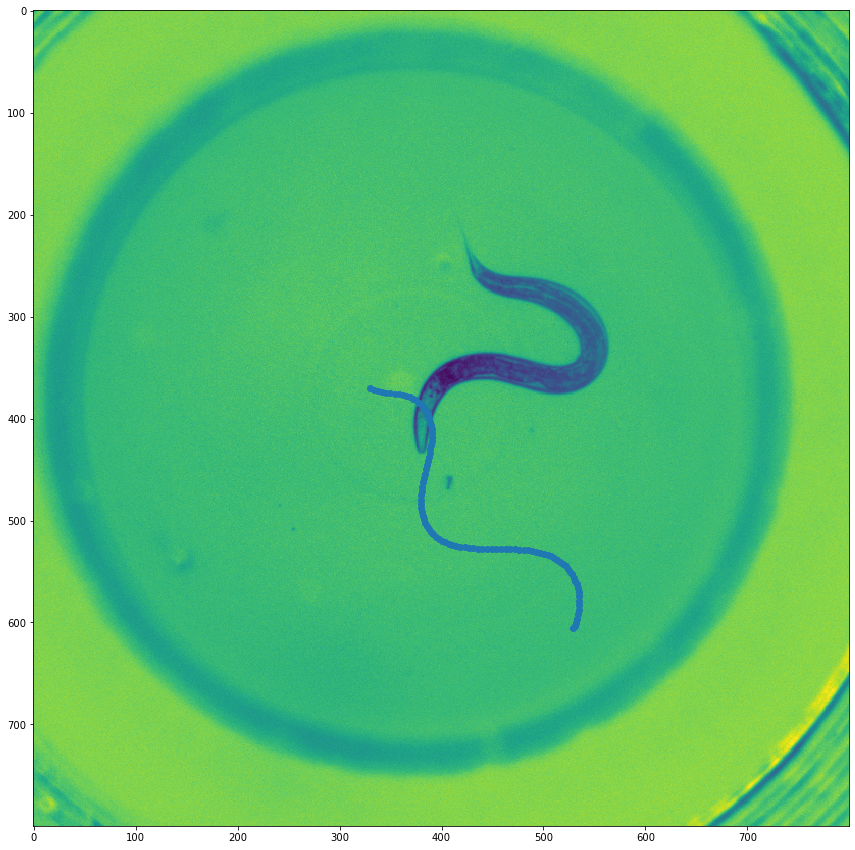

In [155]:
plt.figure(figsize=(25,15))
plt.imshow(img1)
plt.scatter(centerline0[:, 0], centerline0[:, 1])

In [145]:
centerline0.T

array([[331.23667384, 397.51080853],
       [333.09884226, 395.3937065 ],
       [335.25234962, 393.378485  ],
       [337.72687881, 391.4819881 ],
       [340.52918123, 389.72303072],
       [343.64624704, 388.12188201],
       [347.04847536, 386.69974862],
       [350.6928445 , 385.47825803],
       [354.52608221, 384.47894186],
       [358.48783588, 383.72271921],
       [362.51384276, 383.22937994],
       [366.53910023, 383.01706801],
       [370.50103599, 383.10176479],
       [374.34267706, 383.49677251],
       [378.01555719, 384.21222682],
       [381.48083064, 385.25480891],
       [384.70864272, 386.62765168],
       [387.67726302, 388.33027218],
       [390.37221782, 390.35850429],
       [392.78542245, 392.70443128],
       [394.91431365, 395.35631845],
       [396.76098197, 398.29854576],
       [398.33130412, 401.51154038],
       [399.63407537, 404.97170938],
       [400.6801419 , 408.6513723 ],
       [401.48153319, 412.51869377],
       [402.05063093, 416.5376845 ],
 